In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import scipy.stats as st
import glob
from numpy.random import uniform
import librosa

# TODO:
1. new data samples
2. more reduction?
3. listen to pcs
4. try sampling random combinations of pcs

In [29]:
def zero_pad(M):
    maxlen = max(len(r) for r in M)

    Z = np.zeros((len(M), maxlen))
    for enu, row in enumerate(M):
        Z[enu, :len(row)] += row 
    return Z

def trunc(M):
    mean_len = 2*round(np.mean([len(r) for r in M]))
    Z = np.zeros((len(M), mean_len))
    for enu, row in enumerate(M):
        Z[enu, :len(row)] += row[:mean_len]
    return Z

def norm(m,M):
    return (m - M.min())/(M.max()-M.min())

# Load the Samples

In [13]:
samples_arr = []
count = 0
file_descs = []
files = glob.glob('TinySOL/*/*/*/*.wav')
print('Row:\t Filename:')
for filename in files:
    try:
        samplerate, samples = wavfile.read(filename)
        if len(samples.shape) > 1:
            samples = samples[:,0]
        if len(samples) <= 250000:
         
            count += 1
            samples_arr.append(samples)
            file_descs.append(filename.split('/')[4][:-4])
            print(count,'\t'+file_descs[-1])
    except ValueError:
        print('reading failed for ' + filename)

print(samplerate)

Row:	 Filename:
1 	Ob-ord-G#5-pp-N-T11u
2 	Fl-ord-C#7-p-N-T12u
3 	Fl-ord-B3-mf-N-N
4 	Fl-ord-D7-p-N-N
5 	Fl-ord-C7-mf-N-N
6 	Fl-ord-C7-ff-N-N
7 	Fl-ord-D7-ff-N-N
8 	Bn-ord-G2-mf-N-T10d
9 	Bn-ord-F#4-pp-N-N
10 	Bn-ord-D#2-pp-N-N
11 	Bn-ord-A#2-mf-N-T11u
12 	Bn-ord-F4-mf-N-N
13 	Bn-ord-D4-mf-N-N
14 	Bn-ord-A3-pp-N-T11d
15 	Bn-ord-C4-pp-N-N
16 	Bn-ord-A#4-mf-N-T14u
17 	Bn-ord-E2-mf-N-T10u
18 	Bn-ord-D#5-mf-N-N
19 	Bn-ord-B3-ff-N-N
20 	Bn-ord-G4-ff-N-N
21 	Bn-ord-C5-mf-N-N
22 	Bn-ord-A2-mf-N-N
23 	Bn-ord-D#4-pp-N-N
24 	Bn-ord-F3-pp-N-T15d
25 	Bn-ord-A#3-mf-N-N
26 	Bn-ord-B3-mf-N-N
27 	Bn-ord-C#4-mf-N-N
28 	Bn-ord-G4-mf-N-N
29 	Bn-ord-G#3-mf-N-N
30 	Bn-ord-D5-mf-N-N
31 	Bn-ord-A3-ff-N-T14d
32 	Bn-ord-F3-mf-N-N
33 	Bn-ord-E4-pp-N-N
34 	Bn-ord-D#3-mf-N-N
35 	Bn-ord-A4-mf-N-T14u_R100d
36 	Bn-ord-C2-pp-N-T11d_R100u
37 	Bn-ord-C#3-mf-N-R100d
38 	Bn-ord-A2-ff-N-T11d
39 	Bn-ord-G2-pp-N-N
40 	Bn-ord-F#4-mf-N-N
41 	Bn-ord-A2-pp-N-N
42 	Bn-ord-C3-mf-N-R100u
43 	Bn-ord-C#3-pp-N-N
44 	Bn-ord-D3-mf-N-N


In [14]:
n = len(samples_arr)
X = trunc(samples_arr)
downscale = 5
X = signal.decimate(X, downscale, axis = 1)
samplerate = samplerate//downscale

# test downsampling
wavfile.write(f'out/test_reconst.wav', samplerate, norm(X[0]))

In [17]:
wavfile.write(f'out/test_reconst.wav', samplerate, norm(X[0]))

In [18]:
wavfile.write(f'out/test_og.wav', samplerate*5, norm(samples_arr[0]))

In [20]:
X.shape

(509, 77484)

# STFT Analysis

In [21]:
# we want to do PCA on the fourier transform of the signal
def fourier_trans(x, samplerate):
    f, t, spec = signal.stft(x, samplerate, nperseg=1000)
    return spec, f, t

# returns the fundamental frequency of a list of samples in herz or by note name
# by identifying the relative peaks in the fourier transform
def get_fundamental(x, samplerate, note_name = False):
    x_f = np.fft.rfft(x)
    fs = np.fft.rfftfreq(len(x), 1/samplerate)
    #plt.plot(fs[:30000], x_f[:30000])
    # oh... lol... I didn't know how to do fft with non-1 samplerate..., but usually one is fine
    for rel_thresh in np.linspace(1/3, 0.01, 10):
        peaks = signal.find_peaks(np.abs(x_f), height=np.max(np.abs(x_f))*rel_thresh)[0]
        if peaks.any():
            break
    else:
        return None
    freq_index = peaks[0]
    freq = round(fs[freq_index], 1)

    if not note_name:
        return freq
    else:
        return librosa.hz_to_note(freq)

def idx_of_partial(freq):
    return np.argmin(np.abs(freqs - freq))

def partial_embedding(x, x_fund, freqs, samplerate, num_partials=20, partial_width=5):
    """
    Unfortunately, the full fourier transform is pretty sparse, and too big to perform SVD on directly
    Instead, we have to make a denser embedding (which we can later invert) that consists of the
    amplitude envelopes of the first num_partials partials.
    Vibrato, however, means that amplitudes can be spread across neighboring partials, so we
    can include surrounding partials using the partial_width argument
    This makes the embedding larger by a factor of partial_width, but results in significantly
    less loss of information, so inverting the embedding sounds much more like the original sound
    """
    x_f = fourier_trans(x, samplerate)[0]
    embedding = np.zeros((num_partials*partial_width, x_f.shape[1])).astype('complex128')
    
    row = 0
    partials = get_partials(x_fund, freqs, num_partials, partial_width)
    for row, freq in enumerate(partials):
        if freq <= np.max(freqs):
            partial_idx = idx_of_partial(freq)
        else: 
            break
            
        if partial_idx < min(len(x_f), len(freqs)):
            embedding[row] = x_f[partial_idx]
        
    return embedding, partials

def get_partials(fund, freqs, num_partials=20, partial_width=5):
    partials = fund*np.arange(1,num_partials)
    wide_partials = []
    off = partial_width//2
    for freq in partials:
        if freq <= np.max(freqs):
            partial_idx = idx_of_partial(freq)
        else: 
            break
        for i in range(partial_width):
            band_partial_idx = partial_idx+i-off
            if band_partial_idx < len(freqs):
                wide_partials.append(freqs[band_partial_idx])
            
    return wide_partials


def smooth(x, sigma):
    # smooth to remove vibrato in get_freq, or just remove noise
    # using gaussian kernel with sigma=2
    kern_domain = np.linspace(-2, 2, 21+1)
    gaussian_kernel = st.norm.pdf(kern_domain, scale=sigma)
    return np.convolve(x, gaussian_kernel, mode='same')


def embedding_inverse(embedded, partials, freqs, samplerate, check_x_f=False):
    """
    This function is the inverse of partial_embedding:
    given a partials-only embedding, return approximation of original x
    Thus, we will need it to get a soundfile back from a projected pca vector
    """
    x_f = np.zeros((len(freqs), embedded.shape[1])).astype('complex128')
    
    
    for pamps, partial in zip(embedded, partials):
        x_f[idx_of_partial(partial)] = pamps

    if not check_x_f:
        t, x = signal.istft(x_f, samplerate)
        return t, x 
    else:
        return x_f

In [22]:
# this is the data matrix with each row being replaced by its full fourier transform 
# we will use it to compare to X_f_embed which consists of the embedded fourier transforms
X_f, freqs, t = fourier_trans(X, samplerate)

In [24]:
# test the get_fundamental function by comparing its estimate to the corresponding file description
freq_hat = [get_fundamental(x, samplerate, True) for x in X]
for i, (name, freq) in enumerate(zip(file_descs, freq_hat)):
    print(i, name, ':', freq)

0 Ob-ord-G#5-pp-N-T11u : G♯5
1 Fl-ord-C#7-p-N-T12u : C♯7
2 Fl-ord-B3-mf-N-N : B3
3 Fl-ord-D7-p-N-N : D7
4 Fl-ord-C7-mf-N-N : C7
5 Fl-ord-C7-ff-N-N : C7
6 Fl-ord-D7-ff-N-N : D7
7 Bn-ord-G2-mf-N-T10d : G4
8 Bn-ord-F#4-pp-N-N : F♯4
9 Bn-ord-D#2-pp-N-N : D♯2
10 Bn-ord-A#2-mf-N-T11u : A♯4
11 Bn-ord-F4-mf-N-N : F4
12 Bn-ord-D4-mf-N-N : D5
13 Bn-ord-A3-pp-N-T11d : A4
14 Bn-ord-C4-pp-N-N : C4
15 Bn-ord-A#4-mf-N-T14u : A♯4
16 Bn-ord-E2-mf-N-T10u : E4
17 Bn-ord-D#5-mf-N-N : D♯5
18 Bn-ord-B3-ff-N-N : B4
19 Bn-ord-G4-ff-N-N : G4
20 Bn-ord-C5-mf-N-N : C5
21 Bn-ord-A2-mf-N-N : A4
22 Bn-ord-D#4-pp-N-N : D♯4
23 Bn-ord-F3-pp-N-T15d : F3
24 Bn-ord-A#3-mf-N-N : A♯4
25 Bn-ord-B3-mf-N-N : B4
26 Bn-ord-C#4-mf-N-N : C♯5
27 Bn-ord-G4-mf-N-N : G4
28 Bn-ord-G#3-mf-N-N : G♯4
29 Bn-ord-D5-mf-N-N : D5
30 Bn-ord-A3-ff-N-T14d : A4
31 Bn-ord-F3-mf-N-N : F3
32 Bn-ord-E4-pp-N-N : E5
33 Bn-ord-D#3-mf-N-N : A♯4
34 Bn-ord-A4-mf-N-T14u_R100d : A4
35 Bn-ord-C2-pp-N-T11d_R100u : C2
36 Bn-ord-C#3-mf-N-R100d : G♯4
37 Bn-ord-A2

# Testing the Partial Embeddings

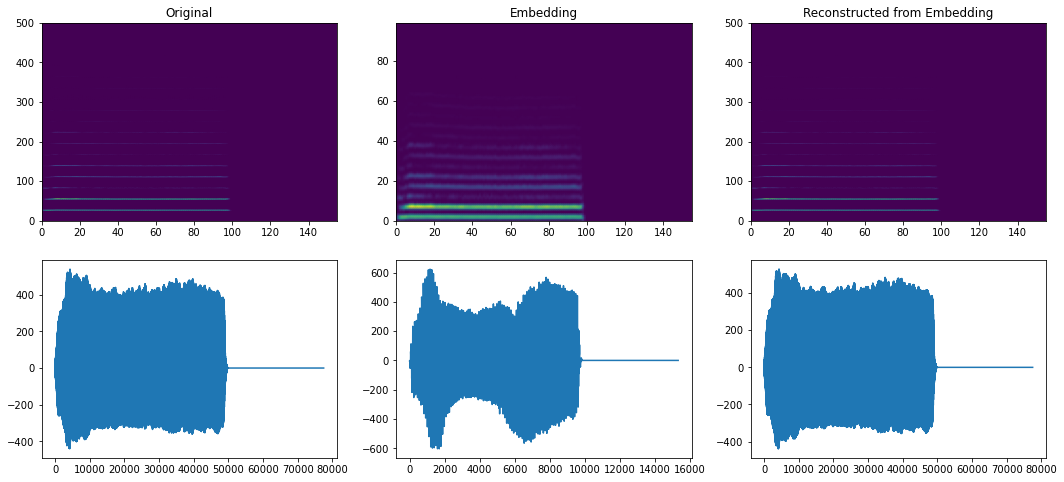

In [30]:
test_ind = 2
test_x = X[test_ind]
test_fund = get_fundamental(test_x, samplerate)
test_embed, test_partials = partial_embedding(test_x, test_fund, freqs, samplerate, partial_width=5)
test_t, test_x_reconst = embedding_inverse(test_embed, test_partials, freqs, samplerate)
test_x_f = embedding_inverse(test_embed, test_partials, freqs, samplerate, check_x_f=True)
test_x_e_t, test_x_e_reconst = signal.istft(test_embed, samplerate)

nrows = 2
ncols = 3
fig, axs = plt.subplots(nrows,ncols, figsize=(ncols*6,nrows*4))

axs[0,0].set_title('Original')
axs[0,1].set_title('Embedding')
axs[0,2].set_title('Reconstructed from Embedding')

axs[0,0].pcolormesh(np.abs(X_f[test_ind]), shading='gouraud')
axs[0,1].pcolormesh(np.abs(test_embed), shading='gouraud')
axs[0,2].pcolormesh(np.abs(test_x_f), shading='gouraud')

axs[1,0].plot(test_x)
axs[1,1].plot(test_x_e_reconst)
axs[1,2].plot(test_x_reconst)


# write the reconstructed audio as a wav file
wavfile.write('out/reconstructed_from_embedding.wav', samplerate, norm(test_x_reconst,X))

# Perform PCA

In [31]:
def pca(X):
    mean = X.mean(axis=0) 
    center = X - mean 
    _, stds, pcs = np.linalg.svd(center/np.sqrt(X.shape[0])) 

    return stds**2, pcs

# embed the data matrix
get_20_partials_w_5 = lambda x: partial_embedding(x, get_fundamental(x, samplerate),
                                                  freqs, samplerate, num_partials=20, partial_width=5)[0]
X_f_embed = np.apply_along_axis(get_20_partials_w_5, 1, X)
_, dimf, dimt = X_f_embed.shape
X_f_linearized = X_f_embed.reshape(n, dimf*dimt)
n_comps = 100

In [ ]:
var_exp, pcs_lin  = pca(X_f_linearized)

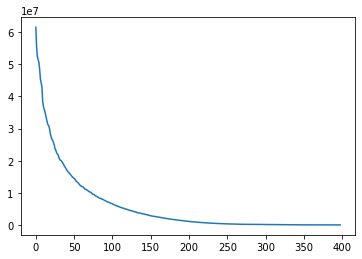

In [20]:
plt.plot(var_exp)

In [21]:
pcs_lin.shape

(13800, 13800)

In [22]:
def reduce_dim(X, pcs, samplerate, num_comps=100):
    if len(X.shape) == 2:
        X_embed = np.apply_along_axis(get_20_partials_w_5, 1, X)
        n, dimf, dimt = X_embed.shape
        X_lin = X_embed.reshape(n, dimf*dimt)
        fund_freqs = [get_fundamental(x, samplerate) for x in X]
    else:
        X_embed = get_20_partials_w_5(X)
        dimf, dimt = X_embed.shape
        X_lin = X_embed.reshape(dimf*dimt)
        fund_freqs = [get_fundamental(X, samplerate)]
    X_proj = X_lin @ pcs[:num_comps].T
    return X_proj, fund_freqs

def expand_dim(X_red, pcs, fund_freqs, freqs, samplerate, num_partials=20, partial_width=5, num_comps=100):
    X_proj = X_red @ pcs_lin[:num_comps]
    if len(X.shape) == 2:
        X_proj = X_proj.reshape(n, dimf, dimt)
    else:
        X_proj = X_proj.reshape(dimf, dimt)
    partials_arr = [get_partials(fund, freqs, num_partials, partial_width) for fund in fund_freqs]
    reconst = [embedding_inverse(x, ps, freqs, samplerate)[1] for x, ps in zip(X_proj, partials_arr)]
    return np.array(reconst)

red, fund = reduce_dim(X, pcs_lin, samplerate, 400)
reconst_x = expand_dim(red, pcs_lin, fund, freqs, samplerate, num_comps=400)

In [23]:
pcs_lin[:400].shape

(400, 13800)

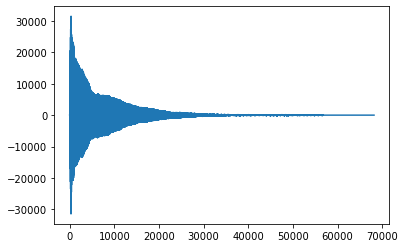

In [24]:
plt.plot(X[206])

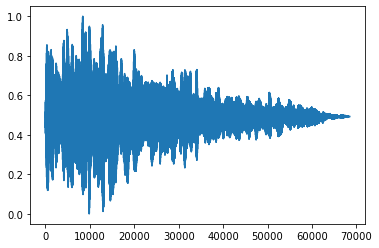

In [27]:
plt.plot(norm(reconst_x[206]))

In [28]:
wavfile.write('og.wav', samplerate, norm(X[206]))
wavfile.write('test.wav', samplerate, norm(reconst_x[206]))

In [29]:
pcs_lin[:400].shape

(400, 13800)

/home/evgerritz/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


KeyboardInterrupt: 

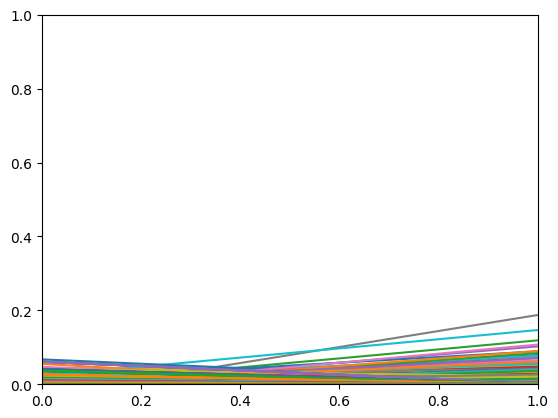

In [118]:
plt.plot(pcs_lin)